In [1]:
import torch
import matplotlib.pyplot as plt
import scipy.io as scio
import numpy as np
import physo
from physo.learn import monitoring
from physo.task  import benchmark

# Device
DEVICE = 'cpu'
if torch.cuda.is_available():
    DEVICE = 'cuda'
print(DEVICE)

# Seed
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

Parallel mode is not available because physo is being ran from a notebook on a system returning multiprocessing.get_start_method() = 'spawn' (typically MACs/Windows). Run physo from the terminal to use parallel mode.
Parallel mode is not available because physo is being ran from a notebook on a system returning multiprocessing.get_start_method() = 'spawn' (typically MACs/Windows). Run physo from the terminal to use parallel mode.

default get_start_method : spawn
Running from notebook : True
Is CUDA available : False
Total nb. of CPUs :  32
Recommended config {'parallel_mode': False, 'n_cpus': 32}
Parallel mode is not available because physo is being ran from a notebook on a system returning multiprocessing.get_start_method() = 'spawn' (typically MACs/Windows). Run physo from the terminal to use parallel mode.
Parallel mode is not available because physo is being ran from a notebook on a system returning multiprocessing.get_start_method() = 'spawn' (typically MACs/Windows). Run physo f

c:\users\dell\physo\physo\physym\execute.py:182: UserWarning: Parallel mode is not available because physo is being ran from a notebook on a system returning multiprocessing.get_start_method() = 'spawn' (typically MACs/Windows). Run physo from the terminal to use parallel mode.
  warnings.warn(msg)
c:\users\dell\physo\physo\physym\reward.py:229: UserWarning: Parallel mode is not available on this system, switching to non parallel mode.
  warnings.warn("Parallel mode is not available on this system, switching to non parallel mode.")


In [2]:
# Load origin dataset(dsmc)
train_data = scio.loadmat('../data/Taylor_vortex_flow.mat')

u = train_data['u'] # m1 s-1
v = train_data['v'] # m1 s-1
vor = train_data['vor'] # s-1
vor_x = train_data['vor_x'] # m-1 s-1
vor_xx = train_data['vor_xx'] # m-2 s-1
vor_y = train_data['vor_y'] # m-1 s-1
vor_yy = train_data['vor_yy'] # m-2 s-1
u_x = train_data['u_x'] # s-1
u_xx = train_data['u_xx'] # m-1 s-1
u_y = train_data['u_y'] # s-1
u_yy = train_data['u_yy'] # m-1 s-1
v_x = train_data['v_x'] # s-1
v_xx = train_data['v_xx'] # m-1 s-1
v_y = train_data['v_y'] # s-1
v_yy = train_data['v_yy'] # m-1 s-1
X_array = np.stack((u, v,vor, vor_x,vor_xx, vor_y,vor_yy, u_x, u_xx, u_y, u_yy, v_x, v_xx, v_y, v_yy), axis=0)

vis_c = torch.tensor(np.array(15.44)).to(DEVICE) # m2 s-1

Y = 15.44 * (vor_xx + vor_yy) - (u * vor_x + v * vor_y)      # s-2  Generate clean data  Target variable is the vor_t.

X_array = X_array.reshape((X_array.shape[0],X_array.shape[1]))
Y = Y.reshape((Y.shape[0],))

If using fully clean data

Y = vor_xx * vis_c + vor_yy * vis_c-u * vor_x - v* vor_y

# 自定义参数

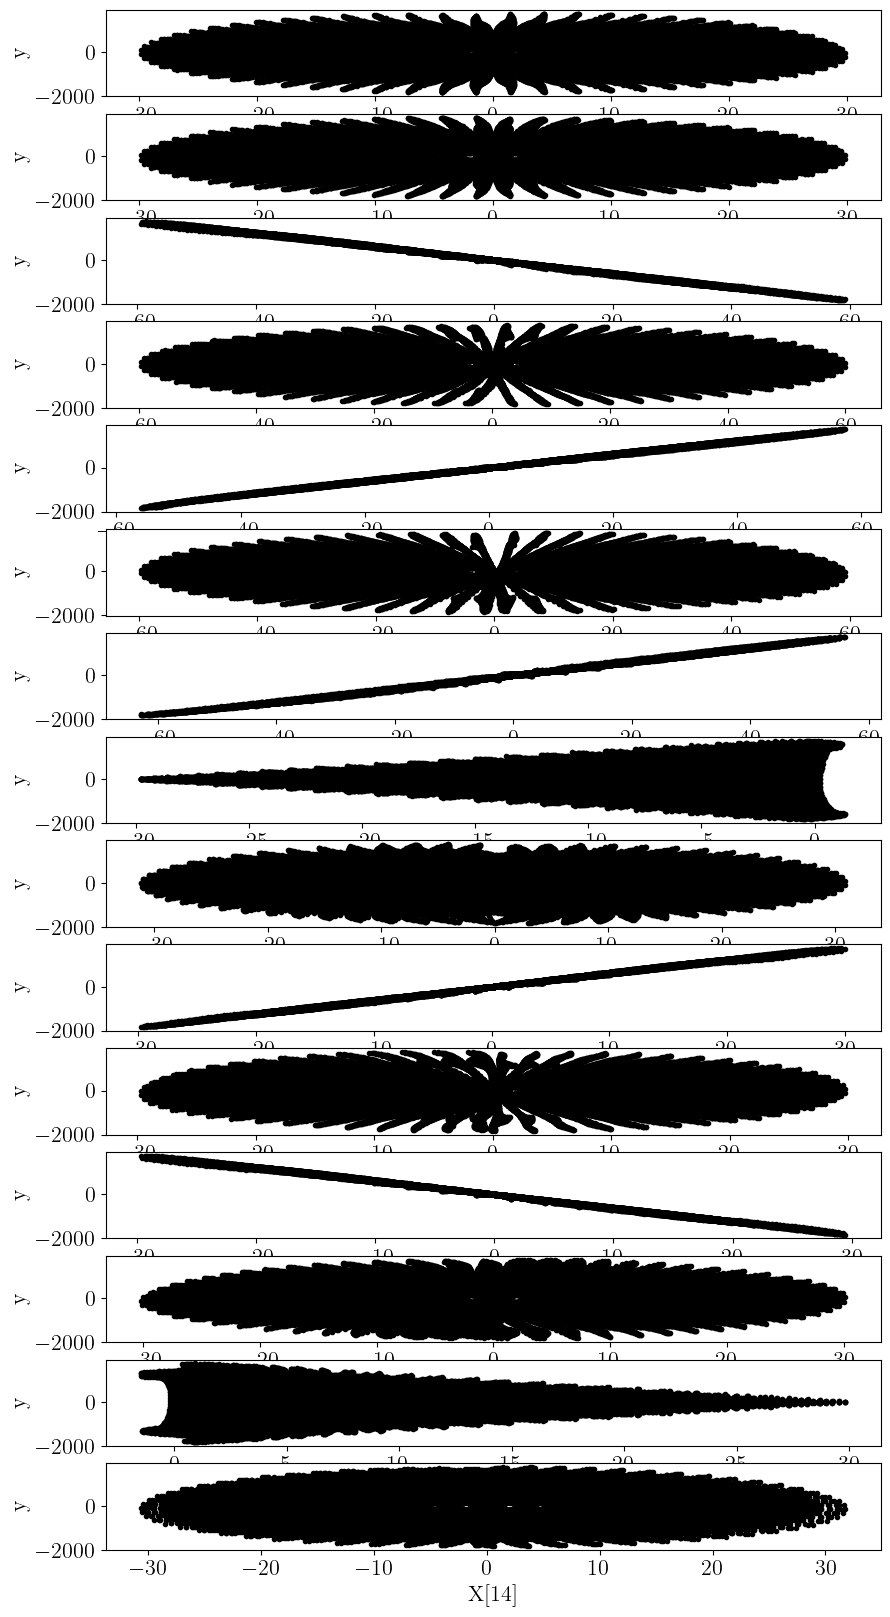

In [3]:
n_dim = X_array.shape[0]
fig, ax = plt.subplots(n_dim, 1, figsize=(10,20))
for i in range (n_dim):
    curr_ax = ax if n_dim==1 else ax[i]
    curr_ax.plot(X_array[i], Y, 'k.',)
    curr_ax.set_xlabel("X[%i]"%(i))
    curr_ax.set_ylabel("y")
plt.show()

In [4]:
X = torch.tensor(X_array).to(DEVICE)
# Output of symbolic function to guess
y = torch.tensor(Y).to(DEVICE)


In [5]:
# Choosing a [Mass, length, time] convention for this run
args_make_tokens = {
                # operations
                "op_names"             : ["mul", "add", "sub", "div"],
                "use_protected_ops"    : True,
                # input variables
                "input_var_ids"        : {"u":0, "v":1,"vor":2, "vor_x":3,"vor_xx":4, "vor_y":5,"vor_yy":6, "u_x":7, "u_xx":8, "u_y":9, "u_yy":10, "v_x":11, "v_xx":12, "v_y":13, "v_yy":14},
                "input_var_units"      : {"u":[1,-1], "v":[1,-1],"vor":[0,-1], "vor_x":[-1,-1],"vor_xx":[-2,-1], "vor_y":[-1,-1],"vor_yy":[-2,-1], "u_x":[0,-1], "u_xx":[-1,-1], "u_y":[0,-1], "u_yy":[-1,-1], "v_x":[0,-1], "v_xx":[-1,-1], "v_y":[0,-1], "v_yy":[-1,-1]},
                "input_var_complexity" : {"u":1., "v":1.,"vor":1., "vor_x":1.,"vor_xx":1., "vor_y":1.,"vor_yy":1., "u_x":1., "u_xx":1., "u_y":1., "u_yy":1., "v_x":1., "v_xx":1., "v_y":1., "v_yy":1.},
                # constants
                "constants"            : {"vis_c" : vis_c          , },
                "constants_units"      : {"vis_c" : [2, -1] , },
                "constants_complexity" : {"vis_c" : 1.              , },
                    }

library_config = {"args_make_tokens"  : args_make_tokens,
                  "superparent_units" : [0, -2],
                  "superparent_name"  : "Y",
                }

In [6]:
reward_config = {
                 "reward_function"     : physo.physym.reward.SquashedNRMSE, # PHYSICALITY
                 "zero_out_unphysical" : True,
                 "zero_out_duplicates" : True,
                 "keep_lowest_complexity_duplicate" : True,
                 "parallel_mode" : True,
                 "n_cpus"        : 32,
                }

In [7]:
BATCH_SIZE = int(1e4)
MAX_LENGTH = 20
GET_OPTIMIZER = lambda model : torch.optim.Adam(
                                    model.parameters(),
                                    lr=0.0025, #0.001, #0.0050, #0.0005, #1,  #lr=0.0025
                                                )

In [8]:
learning_config = {
    # Batch related
    'batch_size'       : BATCH_SIZE,
    'max_time_step'    : MAX_LENGTH,
    'n_epochs'         : 30,
    # Loss related
    'gamma_decay'      : 0.7,
    'entropy_weight'   : 0.005,
    # Reward related
    'risk_factor'      : 0.05,
    'rewards_computer' : physo.physym.reward.make_RewardsComputer (**reward_config),
    # Optimizer
    'get_optimizer'    : GET_OPTIMIZER,
    'observe_units'    : True,
}

Parallel mode is not available because physo is being ran from a notebook on a system returning multiprocessing.get_start_method() = 'spawn' (typically MACs/Windows). Run physo from the terminal to use parallel mode.
Parallel mode is not available because physo is being ran from a notebook on a system returning multiprocessing.get_start_method() = 'spawn' (typically MACs/Windows). Run physo from the terminal to use parallel mode.

default get_start_method : spawn
Running from notebook : True
Is CUDA available : False
Total nb. of CPUs :  32
Recommended config {'parallel_mode': False, 'n_cpus': 32}


c:\users\dell\physo\physo\physym\execute.py:182: UserWarning: Parallel mode is not available because physo is being ran from a notebook on a system returning multiprocessing.get_start_method() = 'spawn' (typically MACs/Windows). Run physo from the terminal to use parallel mode.
  warnings.warn(msg)
c:\users\dell\physo\physo\physym\reward.py:229: UserWarning: Parallel mode is not available on this system, switching to non parallel mode.
  warnings.warn("Parallel mode is not available on this system, switching to non parallel mode.")


In [9]:
free_const_opti_args = {
            'loss'   : "MSE",
            'method' : 'LBFGS',
            'method_args': {
                        'n_steps' : 15,
                        'tol'     : 1e-8,
                        'lbfgs_func_args' : {
                            'max_iter'       : 4,
                            'line_search_fn' : "strong_wolfe",
                                             },
                            },
        }

In [10]:
priors_config  = [
                #("UniformArityPrior", None),
                # LENGTH RELATED
                ("HardLengthPrior"  , {"min_length": 4, "max_length": MAX_LENGTH, }),
                ("SoftLengthPrior"  , {"length_loc": 12, "scale": 5, }),
                # RELATIONSHIPS RELATED
                ("NoUselessInversePrior"  , None),
                ("PhysicalUnitsPrior", {"prob_eps": np.finfo(np.float32).eps}), # PHYSICALITY
                #("OccurrencesPrior", {"targets" : ["1",], "max" : [3,] }),
                 ]

In [11]:
cell_config = {
    "hidden_size" : 128,
    "n_layers"    : 1,
    "is_lobotomized" : False,
}

In [12]:
save_path_training_curves = 'TG_curves3.png'
save_path_log             = 'TG3.log'

run_logger     = monitoring.RunLogger(save_path = save_path_log,
                                      do_save = True)

run_visualiser = monitoring.RunVisualiser (epoch_refresh_rate = 5,
                                           save_path = save_path_training_curves,
                                           do_show   = False,
                                           do_prints = True,
                                           do_save   = True, )

In [13]:
run_config = {
    "learning_config"      : learning_config,
    "reward_config"        : reward_config,
    "free_const_opti_args" : free_const_opti_args,
    "library_config"       : library_config,
    "priors_config"        : priors_config,
    "cell_config"          : cell_config,
    "run_logger"           : run_logger,
    "run_visualiser"       : run_visualiser,
}

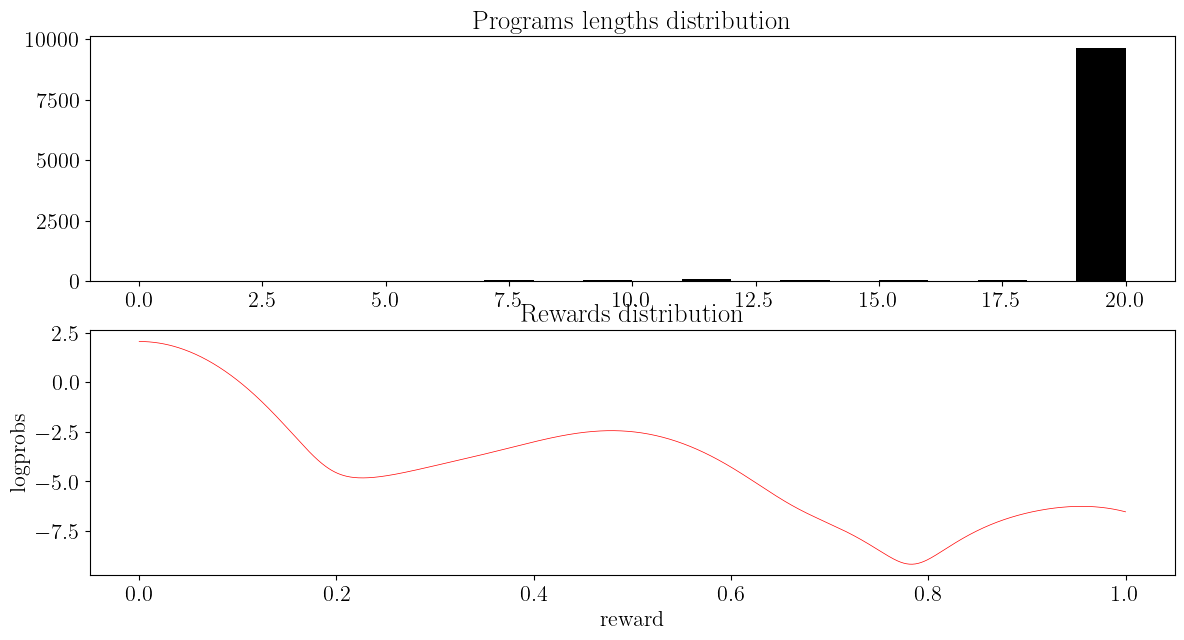

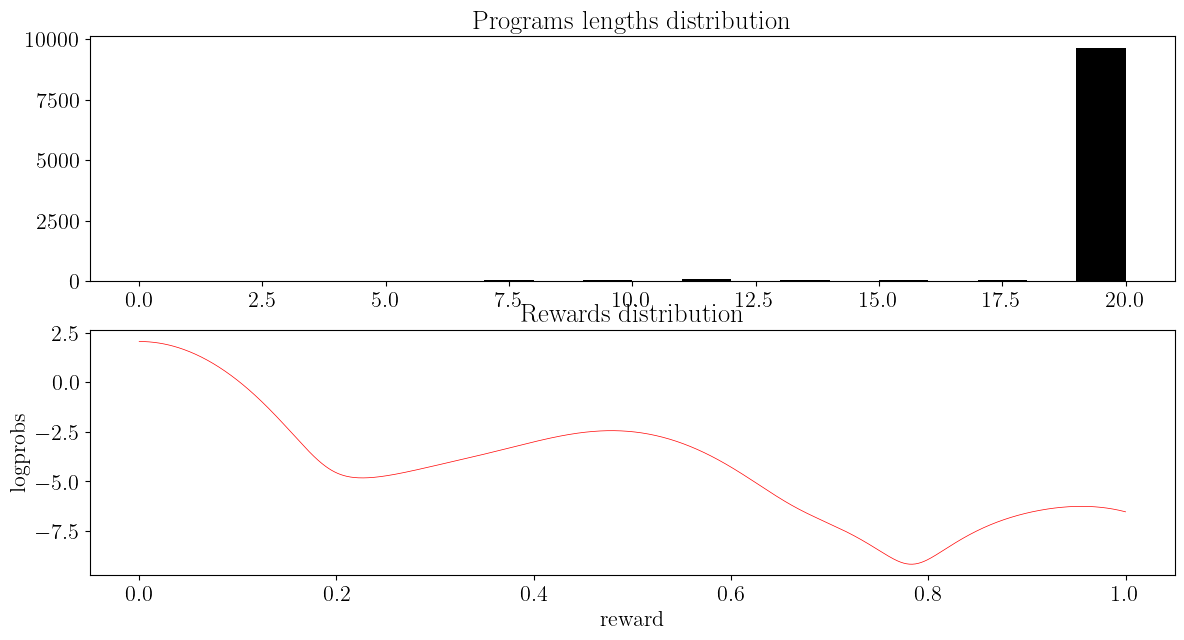

In [14]:
benchmark.dummy_epoch(X, y, run_config)

=========== Epoch 00000 ===========
-> Time 10.87 s

Overall best  at R=0.726068
-> Raw expression : 
u⋅vorₓ + vis_c⋅vorₓₓ

Best of epoch at R=0.726068
-> Raw expression : 
u⋅vorₓ + vis_c⋅vorₓₓ


=========== Epoch 00001 ===========
-> Time 5.70 s

Overall best  at R=0.981399
-> Raw expression : 
uₓₓ⋅(-u + v - (-u + v)) + vis_c⋅vorₓₓ + vis_c⋅vor_yy

Best of epoch at R=0.981399
-> Raw expression : 
uₓₓ⋅(-u + v - (-u + v)) + vis_c⋅vorₓₓ + vis_c⋅vor_yy


=========== Epoch 00002 ===========
-> Time 5.41 s

Overall best  at R=0.981399
-> Raw expression : 
uₓₓ⋅(-u + v - (-u + v)) + vis_c⋅vorₓₓ + vis_c⋅vor_yy

Best of epoch at R=0.981399
-> Raw expression : 
      ⎛  vor           ⎞
vis_c⋅⎜──────── + vorₓₓ⎟
      ⎜⎛ vor  ⎞        ⎟
      ⎜⎜──────⎟        ⎟
      ⎝⎝vor_yy⎠        ⎠


=========== Epoch 00003 ===========
-> Time 5.36 s

Overall best  at R=0.981399
-> Raw expression : 
uₓₓ⋅(-u + v - (-u + v)) + vis_c⋅vorₓₓ + vis_c⋅vor_yy

Best of epoch at R=0.970992
-> Raw expression : 
vis_c⋅vorₓ

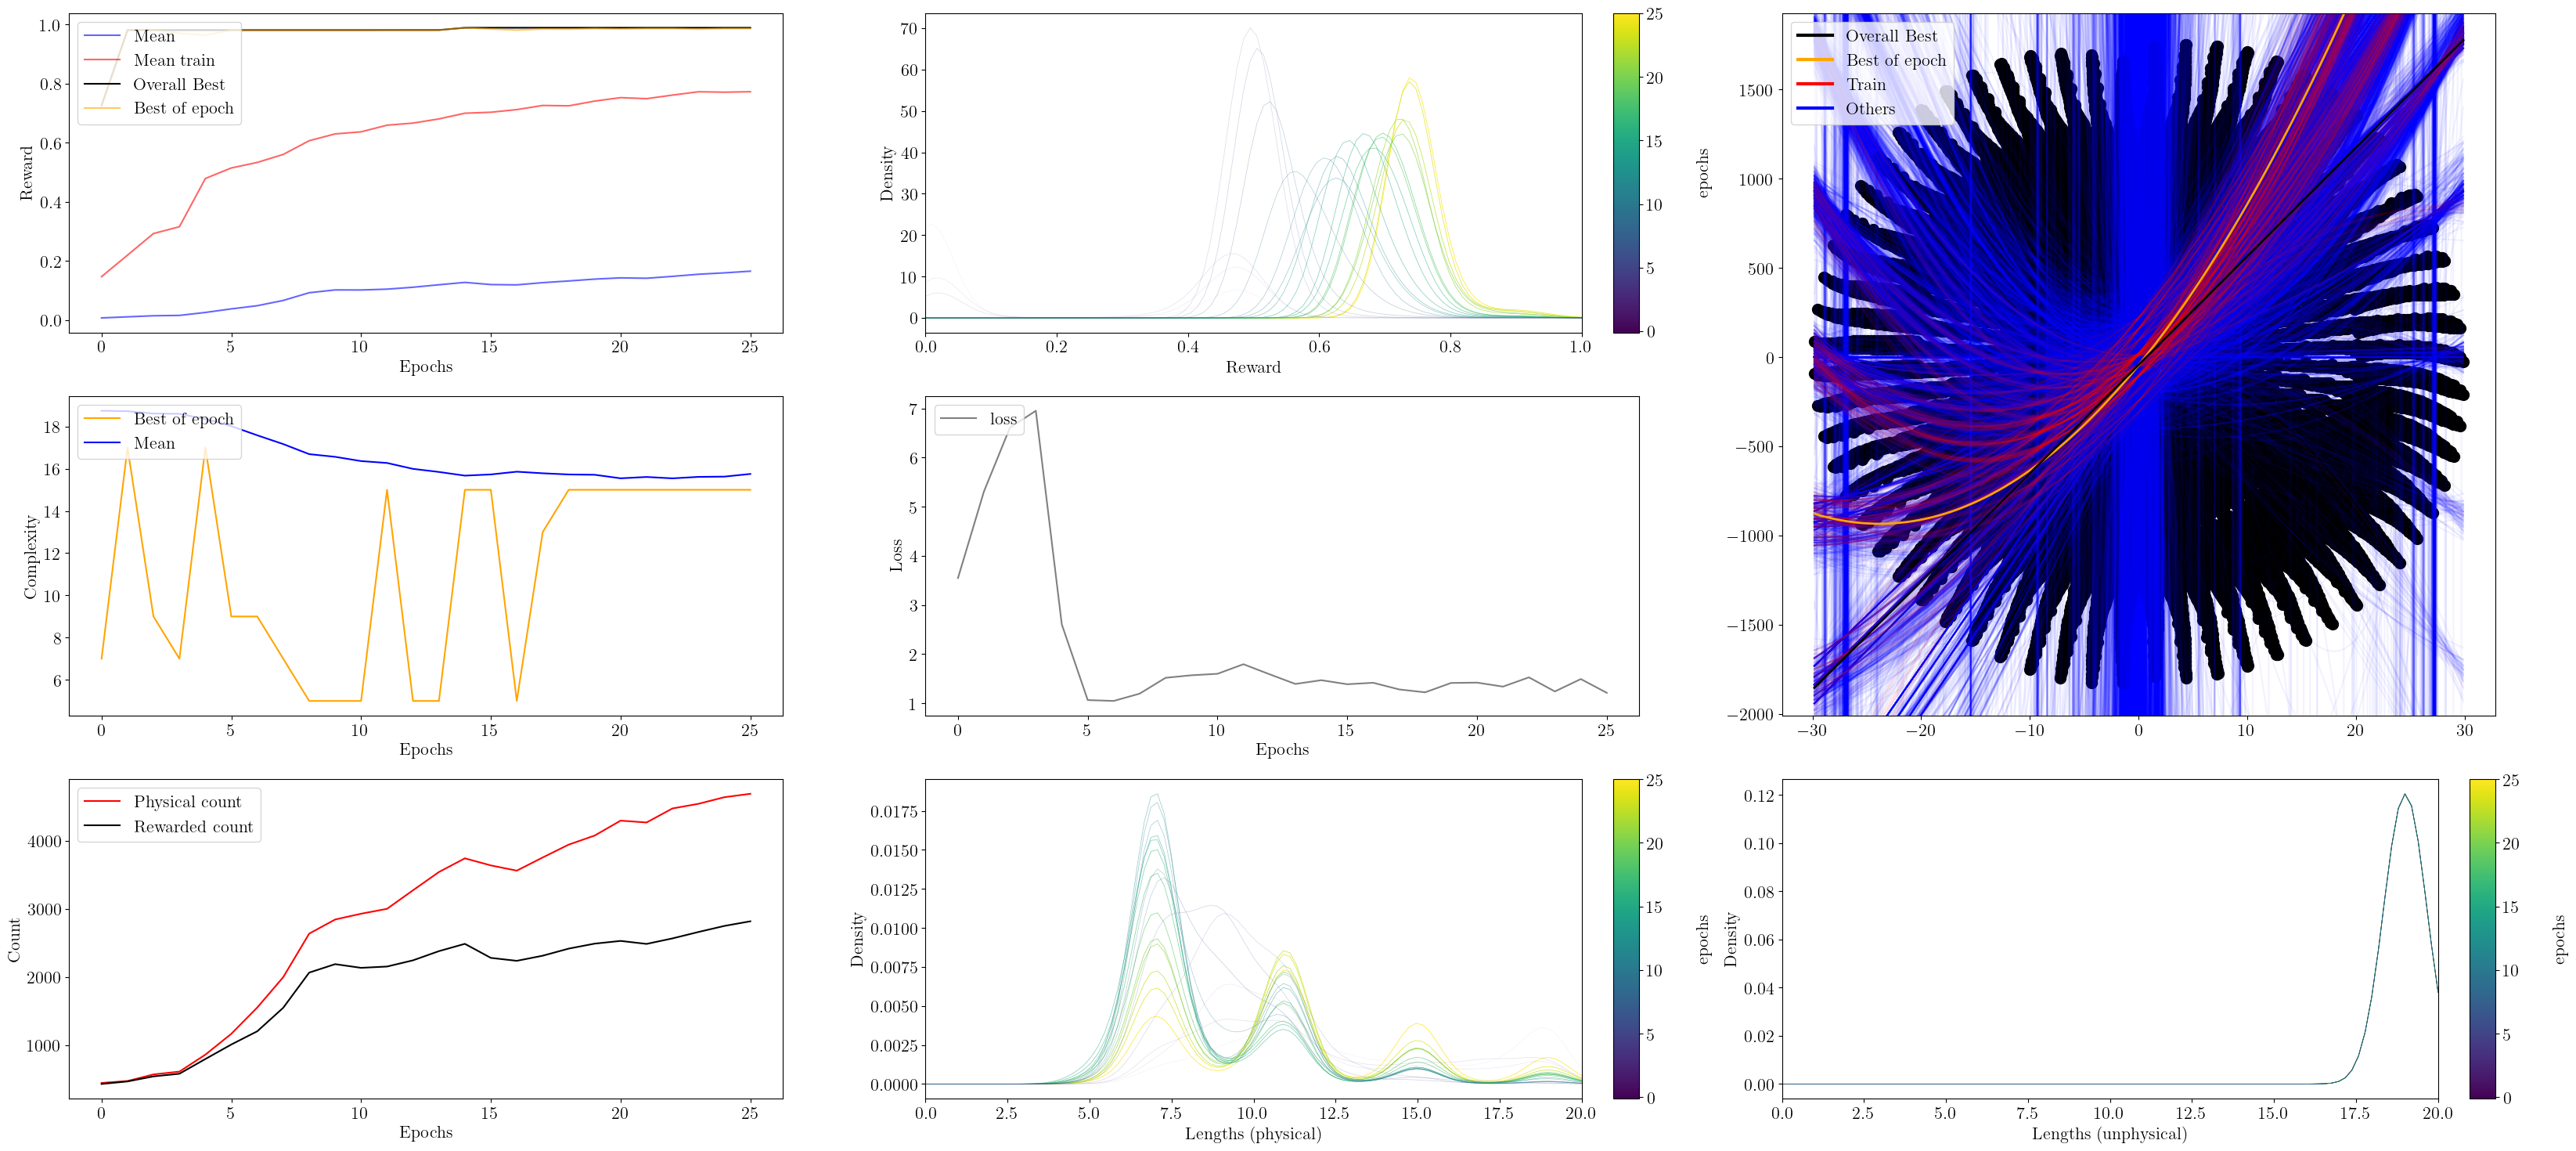

In [15]:
rewards, candidates = physo.fit (X, y, run_config,
                                stop_reward = 0.9999,
                                stop_after_n_epochs = 5)

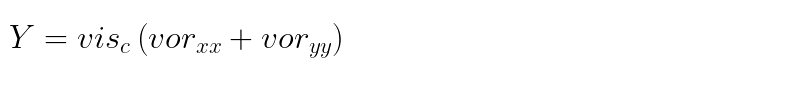

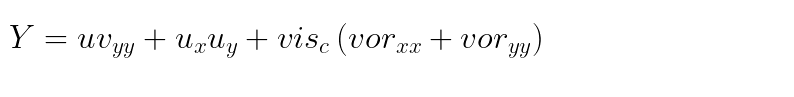

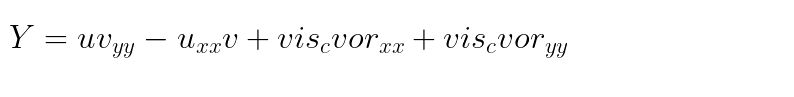

In [16]:
pareto_front_complexities, pareto_front_programs, pareto_front_r, pareto_front_rmse = run_logger.get_pareto_front()
for prog in pareto_front_programs:
    prog.show_infix(do_simplify=True)
    free_consts = prog.free_const_values.detach().cpu().numpy()
    for i in range (len(free_consts)):
        print("%s = %f"%(prog.library.free_const_names[i], free_consts[i]))

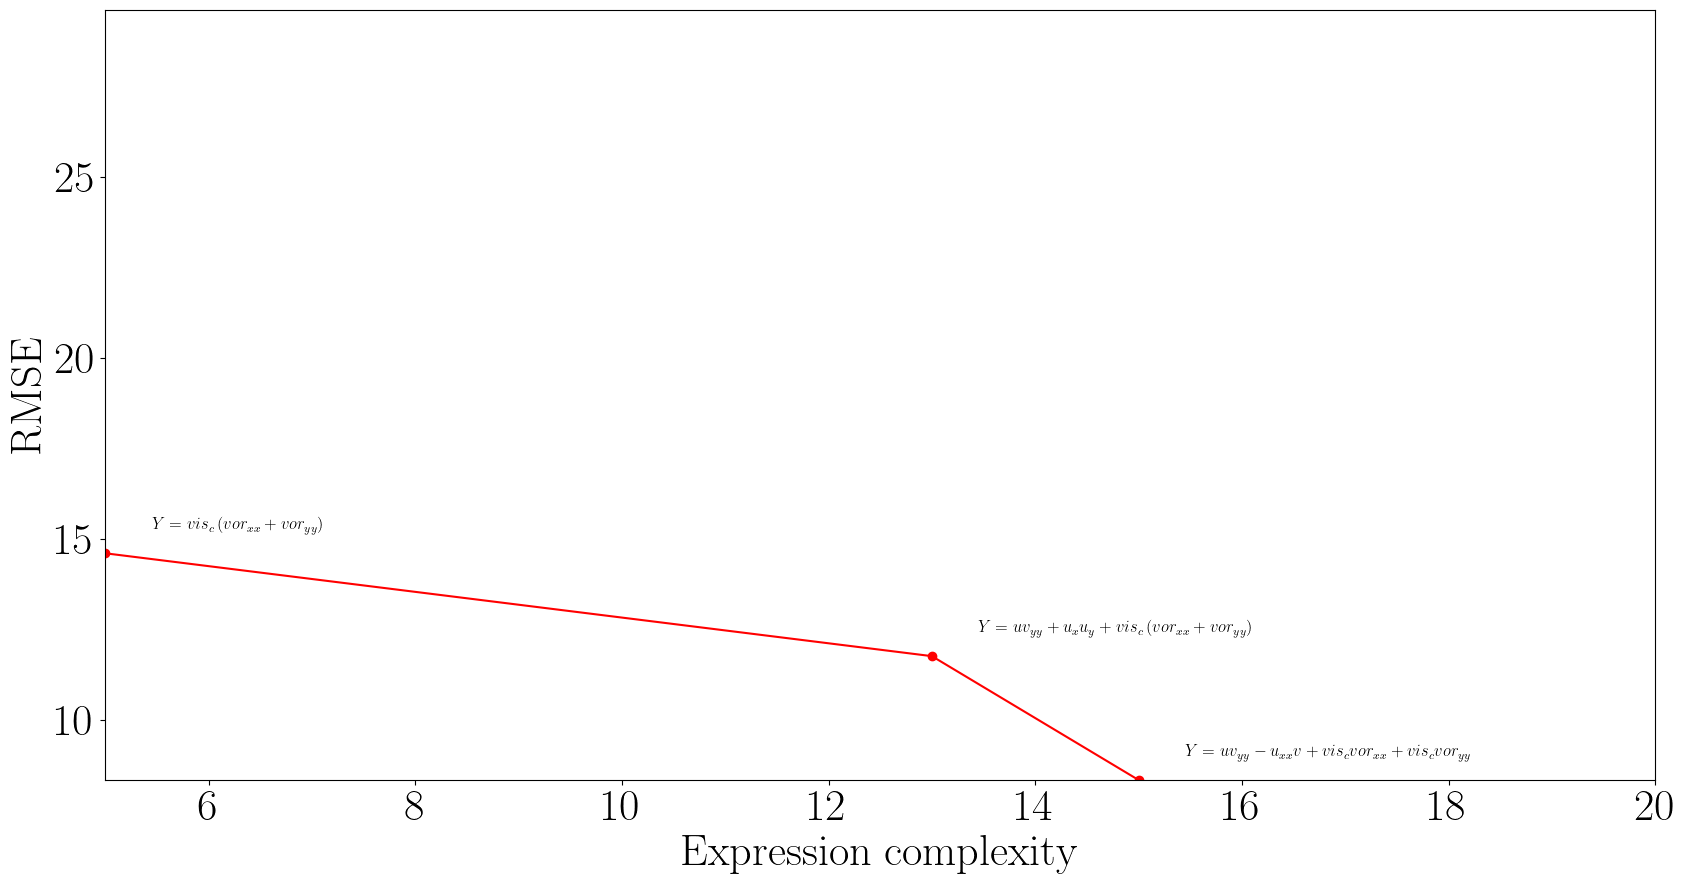

In [17]:
def plot_pareto_front(run_logger,
                      do_simplify                   = True,
                      show_superparent_at_beginning = True,
                      eq_text_size                  = 12,
                      delta_xlim                    = [0, 5 ],
                      delta_ylim                    = [0, 15],
                      frac_delta_equ                = [0.03, 0.03],
                      figsize                       = (20, 10),
                     ):

    pareto_front_complexities, pareto_front_programs, pareto_front_r, pareto_front_rmse = run_logger.get_pareto_front()

    pareto_front_rmse = pareto_front_rmse
    # Fig params
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    # enables new_dummy_symbol = "\square"
    plt.rc('text.latex', preamble=r'\usepackage{amssymb} \usepackage{xcolor}')
    plt.rc('font', size=32)

    # Fig
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(pareto_front_complexities, pareto_front_rmse, 'r-')
    ax.plot(pareto_front_complexities, pareto_front_rmse, 'ro')

    # Limits
    xmin = pareto_front_complexities.min() + delta_xlim[0]
    xmax = pareto_front_complexities.max() + delta_xlim[1]
    ymin = pareto_front_rmse.min() + delta_ylim[0]
    ymax = pareto_front_rmse.max() + delta_ylim[1]
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    # Axes labels
    ax.set_xlabel("Expression complexity")
    ax.set_ylabel("RMSE")


    for i_prog in range (len(pareto_front_programs)):
        prog = pareto_front_programs[i_prog]

        text_pos  = [pareto_front_complexities[i_prog] + frac_delta_equ[0]*(xmax-xmin), 
                     pareto_front_rmse[i_prog]         + frac_delta_equ[1]*(ymax-ymin)]
        # Getting latex expr
        latex_str = prog.get_infix_latex(do_simplify = do_simplify)
        # Adding "superparent =" before program to make it pretty
        if show_superparent_at_beginning:
            latex_str = prog.library.superparent.name + ' =' + latex_str


        ax.text(text_pos[0], text_pos[1], f'${latex_str}$', size = eq_text_size)
        

plot_pareto_front(run_logger)